# 1. Dimension Reduction

## Let's scatter plot some data first

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns; 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

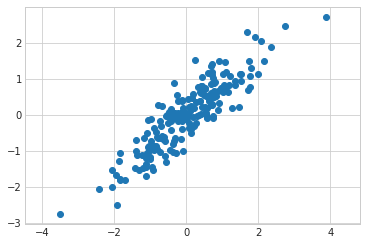

In [2]:
rng = np.random.RandomState(42)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

## What if we do linear regression?
First X on Y:

In [3]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X[:,0].reshape(len(X[:,0]),1), X[:, 1])
lin_reg.intercept_, lin_reg.coef_

(-0.026749756891215545, array([0.81321907]))

Then Y on X :

In [4]:
lin_reg_inverse = LinearRegression(fit_intercept=True)
lin_reg_inverse.fit(X[:,1].reshape(len(X[:,1]),1), X[:, 0])
lin_reg_inverse.intercept_, lin_reg_inverse.coef_

(0.03487043177347125, array([0.9804529]))

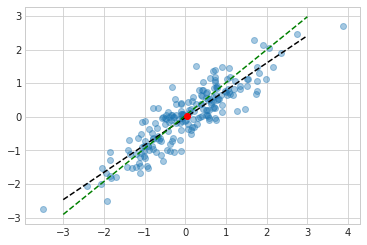

In [5]:
X_new_sample = np.array([[-3], [3]])
plt.plot(X_new_sample, lin_reg.predict(X_new_sample), "k--")
plt.plot(X_new_sample, lin_reg_inverse.predict(X_new_sample), "g--")
plt.scatter(X[:,0], X[:,1],alpha=0.4)
plt.plot(np.mean(X[:,0]), np.mean(X[:,1]), 'ro')
plt.show()

### -- We will got a line describing the linear relationship between two dimensions
**What about correlations?**

In [6]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pca.components_

array([[ 0.74306799,  0.66921593],
       [-0.66921593,  0.74306799]])

In [8]:
pca.explained_variance_

array([1.82927343, 0.10246373])

In [9]:
np.cumsum(pca.explained_variance_ratio_)

array([0.94695773, 1.        ])

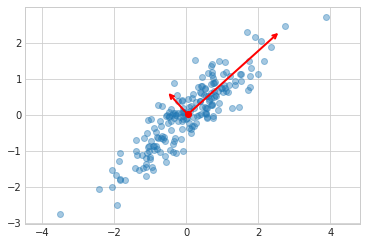

In [10]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color = 'r',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)
plt.plot(np.mean(X[:,0]), np.mean(X[:,1]), 'ro')
## pro rata scale the Principle compoment vector
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2.5 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

#### So what did PCA do?
-- PCA figure out the most significant direction with largest sample variance

[(-3, 3.1),
 Text(0, 0.5, 'component 2'),
 (-5, 5),
 Text(0.5, 0, 'component 1'),
 Text(0.5, 1.0, 'principal components')]

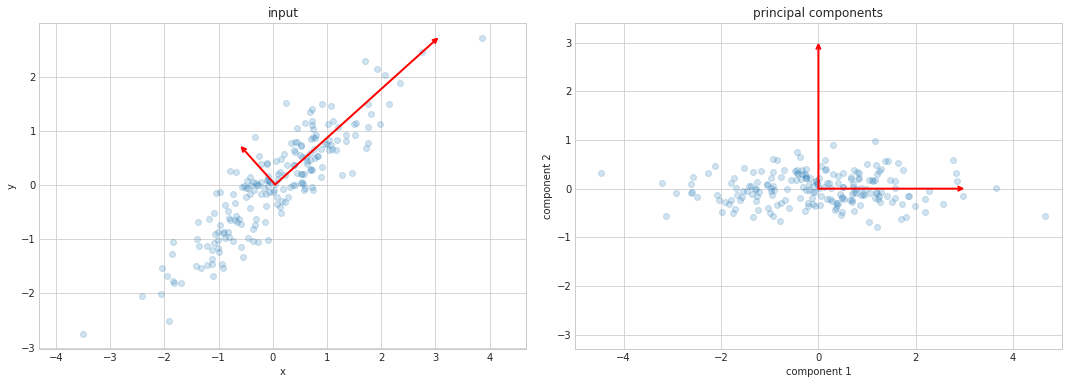

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')
## Here is 2-dim data doing PCA onto 2 major directions, 
## so actually we can explain all of them if we use 2 principle components


# plot principal components, for fitted X
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

### Project samples on to the principle components:
-- what's the difference between this projection and linear regression?

original shape:    (200, 2)
transformed shape: (200, 1)


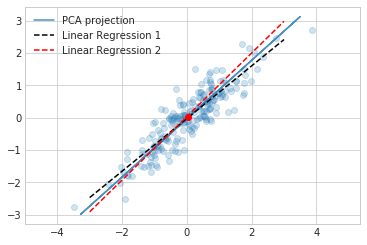

In [12]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], alpha=0.8, label='PCA projection')
plt.plot(X_new_sample, lin_reg.predict(X_new_sample), "k--", label='Linear Regression 1')



lin_reg_inverse = LinearRegression(fit_intercept=True)
lin_reg_inverse.fit(X[:,1].reshape(len(X[:,1]),1), X[:, 0])
X_new_inverse = np.array([[-3], [3]])
X_predict_inverse = lin_reg_inverse.predict(X_new_inverse)
plt.plot(X_new_inverse, X_predict_inverse, "r--", label='Linear Regression 2')
plt.plot(np.mean(X[:,0]), np.mean(X[:,1]), 'ro')
plt.legend()
plt.axis('equal');

#### While linear regression cannot serve as dimension reduction, PCA can.
If we project the datasets to principle compoments, we can get a compression of the original dataset

As we can see from the chart, PCA projection is different from the linear regression.
PCA describes the inner correlations of the datasets, while linear regression describes the bilateral linear relationship of the target vs regressor.
Now we have 3 lines, where are they going to cross each other?

## SVD Decomposition for PCA


Let's start from **spectrum decomposition, or eigen decomposition**:

For a *Real Symmetric Matrix $A$ (N*N)*, $A$ can be decomposed as : $A = Q\Omega Q^T$, where $Q^T = Q^{-1}$, $Q$ is an orthogonal matrix, with i-th column $q_i$ as eigenvector of $A$, $\Omega = diag\{\lambda_1,...,\lambda_N\}, \lambda_1 \geq ... \geq \lambda_N \geq 0$ are all eigenvalues of $A$

We can also put it as 'A can be orthogonally diagonalized'.

Equivalently, $A^{-1} = (Q\Omega Q^T)^{-1} = Q\Omega^{-1}Q^T = Q(diag\{\lambda_1^{-1},...,\lambda_N^{-1}\})Q^T$

If we expand the expression, we get $$A = \sum_{j=1}^{N}\lambda_j q_j q^{'}_j$$

If $A$ is real but not symmetric, A is a N*N matrix with N linearly independent eigenvector, 
$A = Q\Omega Q^T$ still exists, however $Q$ is nologer orthogonal

Then let's look at SVD decomposition:
$A : m*n, U: m*m, \Sigma: m*n, V: n*n$
$$A = U \Sigma V^T$$
Where $U$ is the left singular matrix, $V$ is the right singular matrix, and $\Sigma$ is the diagonized matrix with rank $k = rank(A)$
So $$ A = \sum_{i=1}^k \sigma_i u_i v_i^T$$, where $u_i$ is the i-th column of $U$, so does $v_i$

... (details for SVD -> PCA)

To use SVD to do the PCA, we need to centralize the data first, substruct the mean of all dimensions:

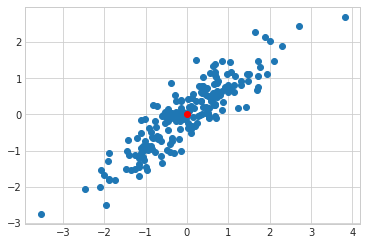

In [13]:
X_centered = X-X.mean(axis=0)
plt.plot(np.array([0]), np.array([0]), 'ro')
plt.scatter(X_centered[:,0], X_centered[:,1])

SVD Decomposition:
$$X = U \Sigma V^T$$

In [14]:
U, sigma, Vt = np.linalg.svd(X_centered)

In [15]:
## s is the diagram of the Sigma matrix
U.shape, sigma.shape, Vt.shape

((200, 200), (2,), (2, 2))

In [16]:
## Since numpy.linalg.svd returns a compact expression of the sigma matrix, we need to manually 
## expand the matrix to the correct dimension, which just adds 0 to the original matrix
m, n = X.shape
Sigma = np.zeros(X_centered.shape)
Sigma[:n, :n] = np.diag(sigma)

In [17]:
## Let's use np.allclose to see if the decomposition is the same as original matrix
np.allclose(np.dot(np.dot(U,Sigma),Vt) ,X_centered)

True

In [18]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [19]:
X2D_using_svd = X2D

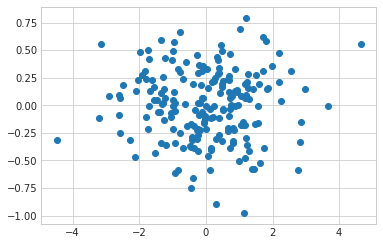

In [20]:
plt.scatter(X2D_using_svd[:,0], X2D_using_svd[:,1])

## Explained ratio for PCA
recall $$A = \sum_{j=1}^{N}\lambda_j q_j q^{'}_j$$
$\lambda_i$ is the eigenvalue of $A$, we can define explained ratio as $$R_k = \frac{\lambda_1+\lambda_2+...+\lambda_k}{\lambda_1+\lambda_2+...+\lambda_N}$$

This represents to what ratio the first k-th principle components explain the total variance of the original dataset.

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

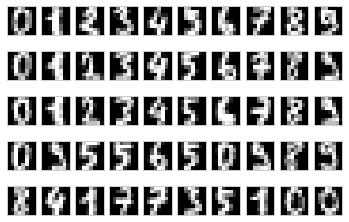

In [22]:
## Show MNIST dataset
fig, ax = plt.subplots(5, 10, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

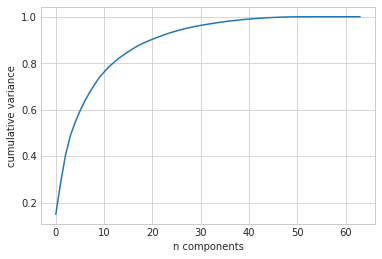

In [23]:
model = PCA(64).fit(digits.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

In [24]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [25]:
facepca = PCA(150)
facepca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

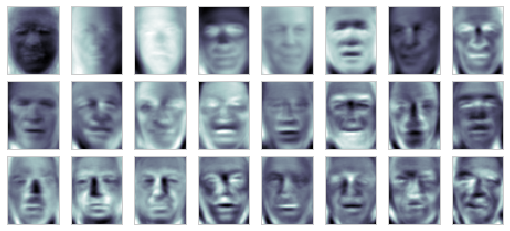

In [26]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(facepca.components_[i].reshape(62, 47), cmap='bone')

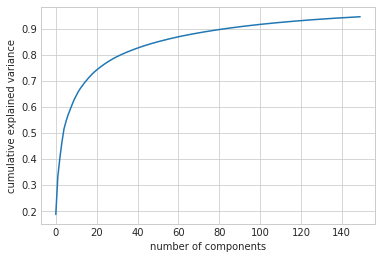

In [27]:
plt.plot(np.cumsum(facepca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Maniford Learning

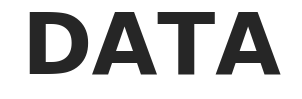

In [61]:
fig, ax = plt.subplots(figsize=(4, 1))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('off')
ax.text(0.5, 0.4, 'DATA', va='center', ha='center', weight='bold', size=85)

fig.savefig('DATA.png')

In [62]:
from matplotlib.image import imread
imgdata = imread('DATA.png')
print('Image Data Shape: ', imgdata.shape) ## (X,Y, color)
N = 1000

# Open this PNG and draw random points from it
imgdata = imgdata[::-1, :, 0].T ## compress to only 1 color dimension
rng = np.random.RandomState(42)
X = rng.rand(4 * N, 2) ## uniform random value from range [0, 1]

Image Data Shape:  (72, 288, 4)


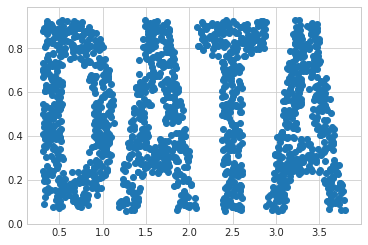

In [63]:
i, j = (X * imgdata.shape).astype(int).T
add_noise = (imgdata[i, j] < 1)
X = X[add_noise]
## Normalize one dimension based on another dimension
X[:, 0] *= (imgdata.shape[0] / imgdata.shape[1])
plt.scatter(X[:,0], X[:,1])

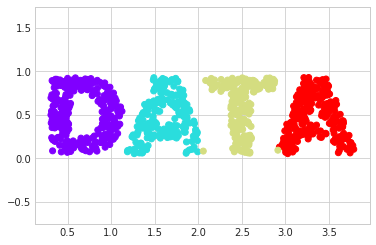

In [64]:
## Sample a subset
X = X[:N]
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 4))
## Add color
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## PCA for visualization

In [32]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print('Original Data Dimensions:', digits.data.shape)
print('Projected Shape:', projected.shape)

Original Data Dimensions: (1797, 64)
Projected Shape: (1797, 2)


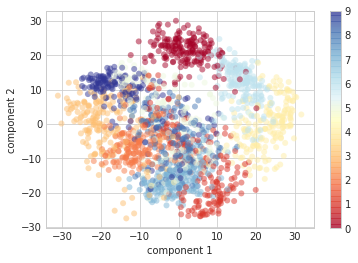

In [33]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('RdYlBu'))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## PCA as Noise Filtering

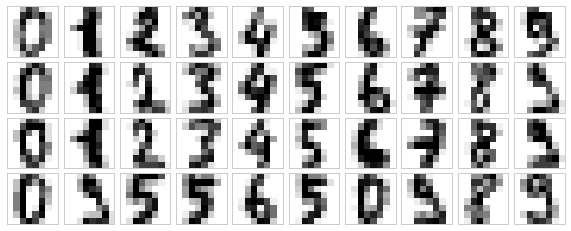

In [34]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

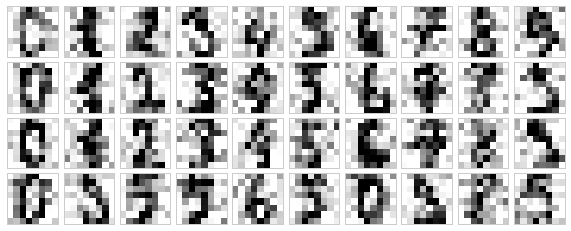

In [35]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [36]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

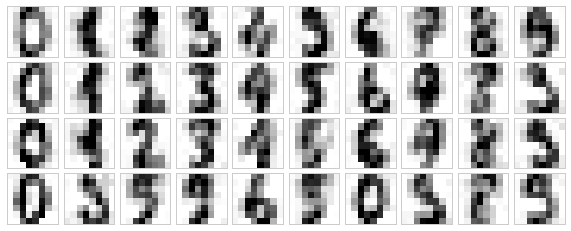

In [37]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

## K-means on digits

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

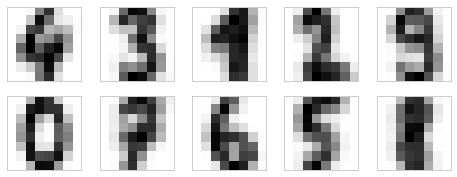

In [39]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [40]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

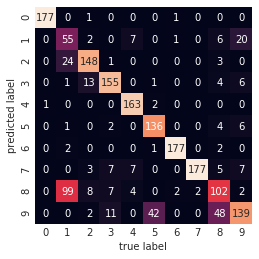

In [42]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# 2. Clustering

## Introduction to K-Means:
The k-means algorithm searches for a predetermined number (k) of clusters with in an unlabeled multidimensional dataset.
The outcome of the algorithm should be like
1. The cluster center is some sort of arithmetic mean of all the points in the certain cluster
2. Each point is closest to its own cluster center.

Let's first take a look at some scatter plot of the dataset:

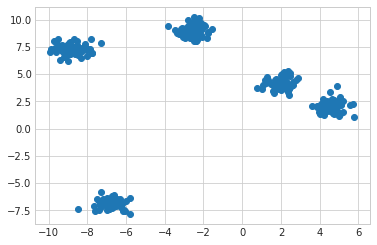

In [66]:
from sklearn.datasets import make_blobs
## Generate isotropic Gaussian blobs for clustering
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
plt.scatter(X[:, 0], X[:, 1]);

And it's easy to eye-screen that the dataset have 5 clusters. 
But how can computer/algorithm know that?

In [79]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans ## y_means is the predicted label of the data

array([3, 0, 3, 4, 3, 2, 0, 1, 2, 0, 4, 3, 4, 3, 0, 3, 4, 4, 0, 3, 3, 4,
       3, 0, 0, 3, 1, 0, 4, 1, 2, 0, 0, 2, 1, 4, 4, 0, 2, 4, 3, 4, 1, 2,
       0, 2, 3, 1, 0, 1, 2, 0, 1, 2, 3, 2, 4, 3, 2, 1, 3, 2, 0, 0, 1, 4,
       1, 1, 1, 1, 4, 1, 2, 0, 2, 3, 2, 2, 0, 3, 1, 3, 3, 0, 3, 1, 2, 4,
       4, 0, 0, 0, 3, 0, 3, 3, 0, 2, 4, 0, 2, 2, 4, 1, 3, 3, 3, 4, 3, 4,
       2, 0, 4, 4, 3, 3, 3, 1, 2, 2, 2, 1, 2, 2, 3, 1, 0, 0, 2, 3, 4, 2,
       4, 3, 3, 3, 3, 4, 1, 0, 3, 2, 3, 4, 0, 3, 0, 1, 4, 1, 4, 1, 1, 4,
       3, 0, 1, 2, 3, 4, 2, 2, 0, 4, 3, 2, 0, 0, 4, 0, 1, 3, 4, 4, 3, 4,
       2, 4, 1, 1, 2, 2, 4, 1, 1, 0, 3, 2, 1, 4, 0, 1, 3, 1, 1, 2, 2, 1,
       0, 4, 2, 1, 4, 4, 2, 3, 3, 1, 1, 3, 1, 2, 0, 1, 3, 4, 2, 2, 1, 0,
       2, 2, 0, 2, 0, 4, 2, 0, 2, 0, 2, 4, 4, 1, 0, 4, 4, 4, 0, 3, 2, 4,
       1, 0, 1, 2, 0, 0, 1, 1, 4, 0, 2, 1, 2, 0, 1, 0, 1, 0, 1, 3, 0, 4,
       4, 3, 0, 4, 1, 4, 2, 1, 1, 3, 3, 2, 4, 4, 0, 0, 2, 3, 3, 4, 4, 1,
       1, 1, 0, 4, 2, 4, 1, 2, 3, 2, 1, 3, 0, 3], d

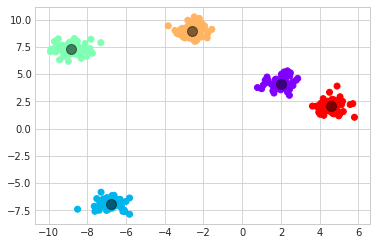

In [80]:
## Color map of rainbow can let you choose how many colors need to be included
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans,  cmap=plt.cm.get_cmap('rainbow', 5))

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

So it's quite close to our intuitive. But how does the magic happen?

- Specify number of clusters K

- Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement

- Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.


#### E-M Algorithm is a generalized form of k-Means
**E-M Algorithm steps:**
1. Initiate some cluster centers by guessing
2. **'E'xpectation**: each point assigned to nearest cluster center, updating expectation of      which cluster each point belongs to.
   
   **'M'aximization**: maximize the fitness 
3. Repeat step 2 until converge

Objective function: For total $m$ points and $K$ clusters:
$$J = \sum_{i=1}^{m}\sum_{k=1}^Kw_{ik}||x^i - \mu_k||^2$$
Where $W_{ik}=1$ for data point $X_i$ if it belongs to cluster k; otherwise $W_{ik}=0$. And $\mu_k$ is the centroid of $x_i$'s cluster

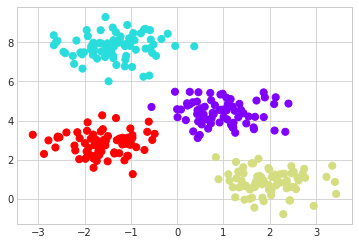

In [119]:
## Implementation of K-Means
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
centers, labels = find_clusters(X, n_clusters=4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 4));

### Potential problems:
- May not be able to find global optimum

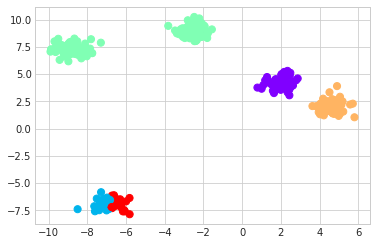

In [120]:
## Try to change the random seed
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
centers, labels = find_clusters(X, 5, rseed=15)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 5));

- We need to assign a number k previous to we know about the data

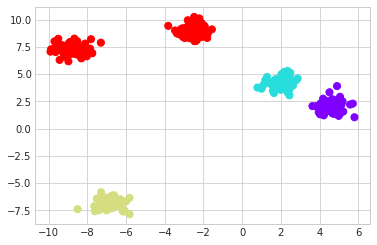

In [121]:
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
centers, labels = find_clusters(X, 4, rseed=42)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 4));

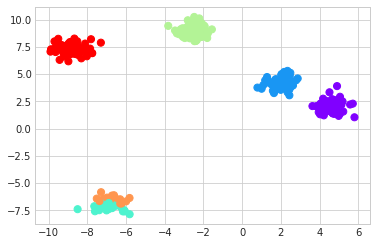

In [122]:
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.5, random_state=42)
centers, labels = find_clusters(X, 6, rseed=42)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 6));

- Limited to linear clusters

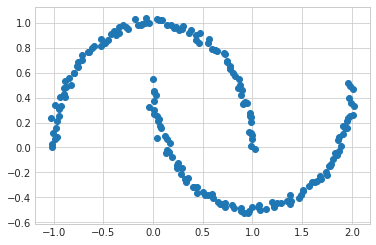

In [124]:
from sklearn.datasets import make_moons
X_moon, y_moon = make_moons(200, noise=0.02, random_state=42)
plt.scatter(X_moon[:,0], X_moon[:,1])

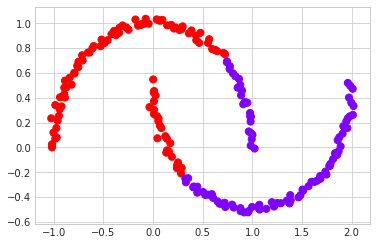

In [125]:
## Self- implemented K-Means:
centers, labels = find_clusters(X_moon, 2, rseed=42)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels,
            s=50, cmap = plt.cm.get_cmap('rainbow', 2));

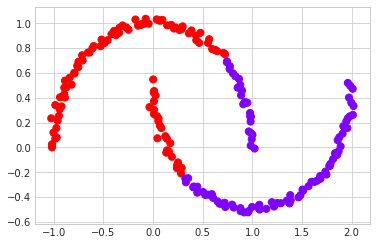

In [127]:
## K-Means from Sklearn:
labels = KMeans(2, random_state=0).fit_predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels,
            s=50, cmap=plt.cm.get_cmap('rainbow', 2));

- How to fix this issue? Let's try kernal tricks similar to the one we have applied in SVM

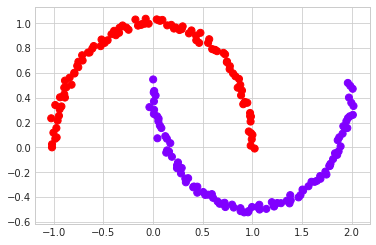

In [128]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels,
            s=50,  cmap=plt.cm.get_cmap('rainbow', 2));

- K-Means can be slow for large datasets

## K-means for color compression

One interesting application of clustering is in color compression within images.

In [44]:
import warnings
warnings.simplefilter('ignore')  
from sklearn.cluster import MiniBatchKMeans

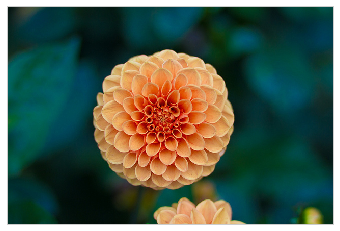

In [45]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

In [46]:
flower.shape

(427, 640, 3)

This image consists 3 dimensions: height * width * color, each height * width is a pixel, and in total it has 427*640 pixels, 427*640 is also the resolution of this image. Color itself contains 3 dimensions, too. A very classical solution for color encoding is RGB, which is also applied here. 3-d array (R,G,B) in each pixel can represent the actual color of the certain pixel. 
https://en.wikipedia.org/wiki/RGB_color_model

In [47]:
255*255*255

16581375

Full RGB encoding can have an image with 16581375 different colors.
While in most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

In [48]:
flower_data = flower / 255.0  ## use 0...1 scale to normalize color data.
flower_data = flower_data.reshape(427 * 640, 3) ## Reshape into 2-d array, strench the image into vector
flower_data.shape

(273280, 3)

In [49]:
def plot_pixels(data, title, colors=None):
    if colors is None:
        colors = data
    N=100000
    # choose a random subset
    rng = np.random.RandomState(42)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    ax[0].set_title('Green vs Red')

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [50]:
## Import for plotting in 3-D
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'Input color space: 16 million possible colors')

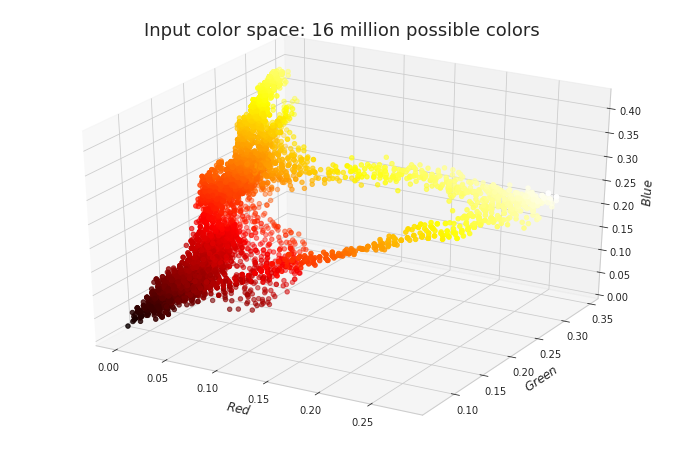

In [51]:
colorset = flower_data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
N_samples = 10000
c_map = (colorset[:N_samples][:,0] + colorset[:N_samples][:,1] + colorset[:N_samples][:,2])/3
cmhot = plt.get_cmap("hot")
ax.scatter(colorset[:N_samples][:,0], colorset[:N_samples][:,1], colorset[:N_samples][:,2], c=c_map,cmap=cmhot)
ax.set_xlabel("$Red$", fontsize=12)
ax.set_ylabel("$Green$", fontsize=12)
ax.set_zlabel("$Blue$", fontsize=12)
ax.set_title('Input color space: 16 million possible colors',fontsize=18)

Text(0.5, 0.92, 'Reduced color space: 16 colors')

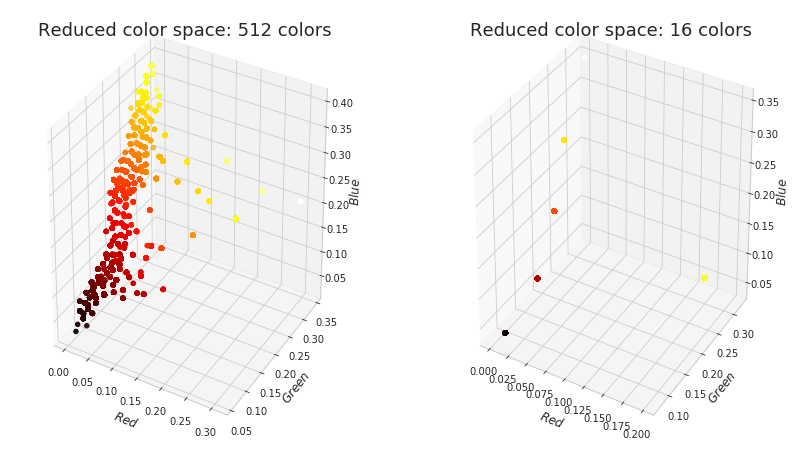

In [52]:
fig = plt.figure(figsize=(14, 8))

kmeans = MiniBatchKMeans(512)
kmeans.fit(flower_data)
new_flower_data = kmeans.cluster_centers_[kmeans.predict(flower_data)]
colorset = new_flower_data
ax = plt.subplot(121, projection='3d')
N_samples = 10000
c_map = (colorset[:N_samples][:,0] + colorset[:N_samples][:,1] + colorset[:N_samples][:,2])/3
cmhot = plt.get_cmap("hot")
ax.scatter(colorset[:N_samples][:,0], colorset[:N_samples][:,1], colorset[:N_samples][:,2], c=c_map,cmap=cmhot)
ax.set_xlabel("$Red$", fontsize=12)
ax.set_ylabel("$Green$", fontsize=12)
ax.set_zlabel("$Blue$", fontsize=12)
ax.set_title("Reduced color space: 512 colors",fontsize=18)

kmeans = MiniBatchKMeans(16)
kmeans.fit(flower_data)
new_flower_data = kmeans.cluster_centers_[kmeans.predict(flower_data)]
colorset = new_flower_data
ax =  plt.subplot(122, projection='3d')
N_samples = 10000
c_map = (colorset[:N_samples][:,0] + colorset[:N_samples][:,1] + colorset[:N_samples][:,2])/3
cmhot = plt.get_cmap("hot")
ax.scatter(colorset[:N_samples][:,0], colorset[:N_samples][:,1], colorset[:N_samples][:,2], c=c_map,cmap=cmhot)
ax.set_xlabel("$Red$", fontsize=12)
ax.set_ylabel("$Green$", fontsize=12)
ax.set_zlabel("$Blue$", fontsize=12)
ax.set_title("Reduced color space: 16 colors",fontsize=18)

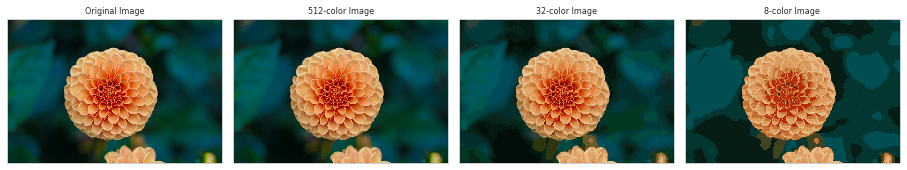

In [53]:
reduced_color_dim = [512, 32, 8]
dimreduced_flower = {}
for new_dim in reduced_color_dim:
    
    kmeans = MiniBatchKMeans(new_dim)
    kmeans.fit(flower_data)
    new_flower_data = kmeans.cluster_centers_[kmeans.predict(flower_data)]
    dimreduced_flower.update({new_dim:new_flower_data})

# flower_recolored = new_flower_data.reshape(flower.shape)

fig, ax = plt.subplots(1, 4, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)

ax[0].imshow(flower)
ax[0].set_title('Original Image', size=8)

ax[1].imshow(dimreduced_flower[512].reshape(flower.shape))
ax[1].set_title('512-color Image', size=8);

ax[2].imshow(dimreduced_flower[32].reshape(flower.shape))
ax[2].set_title('32-color Image', size=8);

ax[3].imshow(dimreduced_flower[8].reshape(flower.shape))
ax[3].set_title('8-color Image', size=8);